<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Deep Learning School FPMI MIPT</b></h3>

<h3 style="text-align: center;"><b>Semantic segmentation</b></h3>


In this task, we will solve the problem of segmentation of medical images.

---


1. First, we will download the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>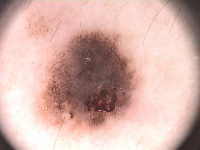</td><td>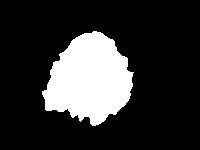</td></tr></table>

2. Unzip the .rar file.

These are photographs of two types of **skin lesions:** melanoma and moles.
In this task, we will not classify them, but we will **segment** them.

In [1]:
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.transform import resize
import numpy as np
import pandas as pd
import time
import copy
import seaborn as sns
import gc
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

#from matplotlib import rcParams
#rcParams['figure.figsize'] = (15,4)

Our dataset structure is as follows:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Here `X.bmp` — the image to be segmented, `X_lesion.bmp` — result

In [2]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Images have different sizes. Let's resize them to $256\times256$ pixels. You can use to resize images [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).


In [3]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

To make sure everything is correct, we will draw some image

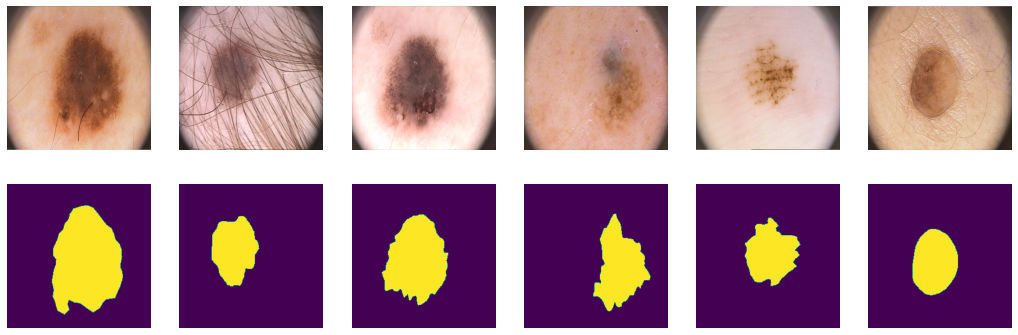

In [6]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Divide our 200 pictures by 100/50/50
  for training, validation and test respectively

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Implementation of various architectures:
Let's write several neural network architectures to solve the problem of semantic segmentation. Let's compare them in terms of quality on the test and try different loss functions for them.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

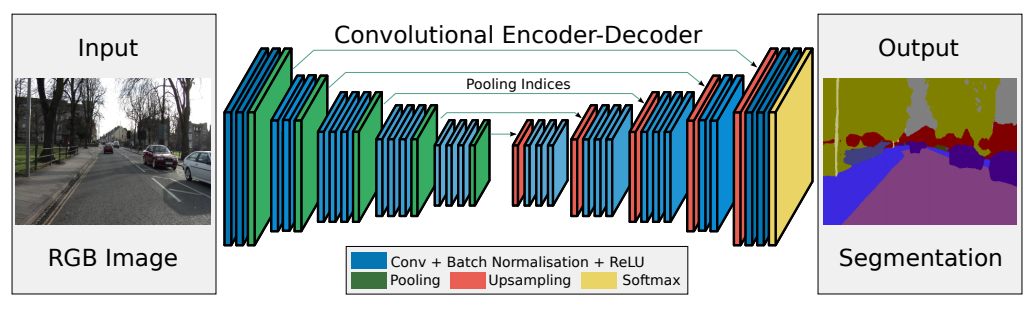

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(*[
                                        nn.Conv2d(3, 64, 3, padding = 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, 3, padding = 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()]
                                        )
        self.pool0 =  nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv1 =  nn.Sequential(
                                        *[nn.Conv2d(64, 128, 3, padding = 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, 3, padding = 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()]
                                        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
                                        *[nn.Conv2d(128, 256, 3, padding = 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, 3, padding = 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU()]
                                        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) 
        self.enc_conv3 = nn.Sequential(
                                       *[ nn.Conv2d(256, 512, 3, padding = 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(512, 512, 3, padding = 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU()]
                                        ) 
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv4 = nn.Sequential(
                                        *[nn.Conv2d(512, 1024, 3, padding = 1),
                                        nn.BatchNorm2d(1024),
                                        nn.ReLU(),
                                        nn.Conv2d(1024, 1024, 3, padding = 1),
                                        nn.BatchNorm2d(1024),
                                        nn.ReLU()]
                                        ) 
        self.pool4 = nn.MaxPool2d(2, 2, return_indices=True)

        #bottleneck
        self.bottleneck_conv_enc = nn.Sequential(*[
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])
        self.bottleneck_pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(2, 2)
        self.bottleneck_conv_dec = nn.Sequential(*[
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),     
                                         nn.ReLU()
                                         ])

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
                                        *[nn.Conv2d(1024, 1024, 3, padding = 1),
                                        nn.BatchNorm2d(1024),
                                        nn.ReLU(),
                                        nn.Conv2d(1024, 512, 3, padding = 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU()]
                                        )
        self.upsample1 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
                                        *[nn.Conv2d(512, 512, 3, padding = 1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(512, 256, 3, padding = 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU()]
                                        )
        self.upsample2 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
                                        *[nn.Conv2d(256, 256, 3, padding = 1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 128, 3, padding = 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()]
                                        )
        self.upsample3 =   nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
                                        *[nn.Conv2d(128, 128, 3, padding = 1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 64, 3, padding = 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()]
                                        )
        self.upsample4 =   nn.MaxUnpool2d(2, 2)
        self.dec_conv4 = nn.Sequential(
                                        *[nn.Conv2d(64, 64, 3, padding = 1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 1, 3, padding = 1)]
                                        )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))
        e4, idx4 = self.pool4(self.enc_conv4(e3))
        # bottleneck
        bottle_enc, bottle_id = self.bottleneck_pool(self.bottleneck_conv_enc(e4))
        bottle_dec = self.bottleneck_conv_dec(self.bottleneck_upsample(bottle_enc, bottle_id))
        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, idx4))
        d1 = self.dec_conv1(self.upsample1(d0, idx3))
        d2 = self.dec_conv2(self.upsample2(d1, idx2))
        d3 = self.dec_conv3(self.upsample3(d2, idx1))
        d4 = self.dec_conv4(self.upsample4(d3, idx0))
        return torch.sigmoid(d4)

## Metric

This section suggests using the following metric to evaluate quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of the pixels found in both the prediction mask and the ground truth mask, while the union (A ∪ B) simply consists of all the pixels found in either the prediction mask or the target mask.

For example, let's look at truth (left) and prediction (right):

![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [12]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-100
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))       
    
    iou = (intersection) / (union + SMOOTH) 
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10 
    
    return iou #thresholded

In [13]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)
            scores += metric(Y_pred.cpu(), Y_label).mean().item()
    return scores/len(data)

## Losss function

НJust as important as the architecture is the definition of the **optimizer** and **loss function.**

The loss function is what we are trying to minimize. Many of them can be used for the task of binary semantic segmentation.

A popular method for binary segmentation is *binary cross entropy*, which is defined as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i) )\right].$$

where $y$ is the target of the desired result and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) that converts a real number $\mathbb R$ to a probability $[0,1]$.

However, this loss suffers from problems of numerical instability. Most importantly, $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first one and is not as prone to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_real, y_pred): 
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1)
    return torch.mean(y_pred -torch.mul(y_real, y_pred)+ torch.log(1 + torch.exp(-y_pred)))

## Model train

We will define a learning loop in a function so we can reuse it.

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    tic = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_iou = []
    epoch_val_iou = []
    best_iou = 0.0
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        loss_f = 0
        iou = 0
        loss_f_val = 0
        iou_val = 0
        model.train()  
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward() 
            opt.step()
            loss_f +=  loss.detach().item()
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)
            iou += iou_pytorch(Y_pred, Y_batch).mean().item()
        epoch_loss = loss_f / len(data_tr)
        epoch_iou = iou / len(data_tr)
        epoch_train_loss.append(epoch_loss)
        epoch_train_iou.append(epoch_iou)
        
        model.eval()
        with torch.no_grad():
            for X_val, Y_val in data_val:
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                Y_pred_val = model(X_val)
                val_loss = loss_fn(Y_val, Y_pred_val)
                loss_f_val +=  val_loss.detach().item()
                Y_pred_val = torch.where(Y_pred_val > 0.5, 1, 0)
                iou_val += iou_pytorch(Y_pred_val, Y_val).mean().item()
        epoch_loss = loss_f_val / len(data_val)
        epoch_iou = iou_val / len(data_val)
        epoch_val_loss.append(epoch_loss)
        epoch_val_iou.append(epoch_iou)
        Y_hat = Y_pred_val.detach().cpu()
        X_batch, Y_batch = X_batch.cpu(), Y_batch.cpu()
        X_val, Y_val = X_val.cpu(), Y_val.cpu()
        Y_pred, Y_pred_val, loss, val_loss = Y_pred.cpu(), Y_pred_val.cpu(), loss.cpu(), val_loss.cpu()
        clear_output(wait=True)
        for k in range(batch_size):
            plt.subplot(2, batch_size, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, batch_size, k+batch_size+1)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f , val_loss: %f' % (epoch+1, epochs, loss, val_loss), fontsize = 16, va = 'bottom')
        plt.show()
        del X_batch, Y_batch, X_val, Y_val, Y_pred, loss, val_loss
        torch.cuda.empty_cache()
        gc.collect()
        if epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())  
        print('_'*30)
    toc = time() - tic
    print('Training complete in {:.0f}m {:.0f}s'.format(toc // 60, toc % 60))
    print('Best val IOU: {:4f}'.format(best_iou))
    model.load_state_dict(best_model_wts)
    stats = epoch_train_loss, epoch_train_iou, epoch_val_loss, epoch_val_iou
    return model, stats

## Train

Let's train our model. It is necessary to train until convergence. If necessary, we will change the number of epochs until the algorithm converges. Convergence is determined by the change in the loss function on the validation set.


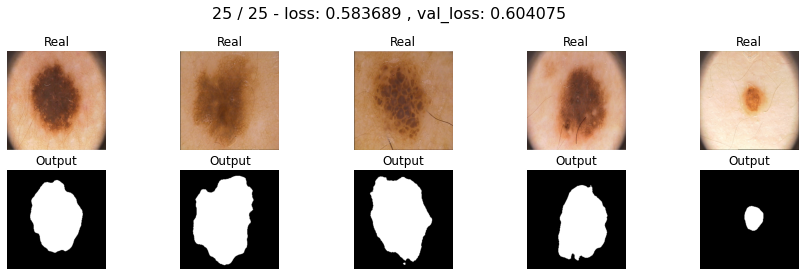

_______________
Training complete in 2m 21s
Best val IOU: 0.848578


In [16]:
model_bce = SegNet().to(device)
max_epochs = 25
optim = torch.optim.Adam(model_bce.parameters(), lr=1e-4) 
segnet_best_model_bce, segnet_statistics_with_bce_loss = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val)

In [17]:
def show_results(statistics, max_epochs):
    sns.set(style="darkgrid", font_scale=1.4)
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].set_title("Train/val losses")
    ax[0].plot(range(max_epochs), statistics[0], label="train_loss", linewidth=2)
    ax[0].plot(range(max_epochs), statistics[2], label="val_loss", linewidth=2)
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[1].set_title("Train/val IOU")
    ax[1].plot(range(max_epochs), statistics[1], label="train_iou", linewidth=2)
    ax[1].plot(range(max_epochs), statistics[3], label="val_iou", linewidth=2)
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    plt.show()

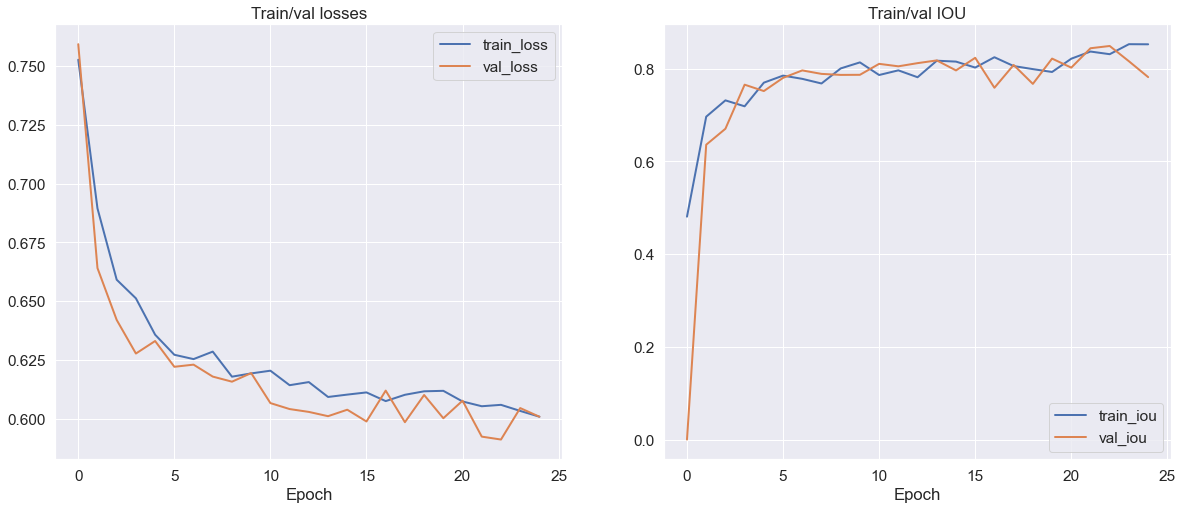

In [18]:
show_results(segnet_statistics_with_bce_loss, max_epochs)

-----------------------------------------------------------------------------------------

## Another loss functions

In this section, we implement two loss functions:
  DICE and focal loss.


**1. Dice coefficient:** Given two masks $X$ and $Y$, the overall metric for measuring the distance between these two masks is given by:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case, we can approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

In [20]:
def dice_loss(y_real, y_pred):
    smooth=1e-6
    inputs = torch.flatten(y_pred)
    targets = torch.flatten(y_real)
    
    intersection = torch.sum(inputs * targets)
    cardinality = torch.sum(inputs + targets)
    
    dice_score = 2. * intersection / (cardinality + smooth)
    return torch.mean(1. - dice_score)

Testing

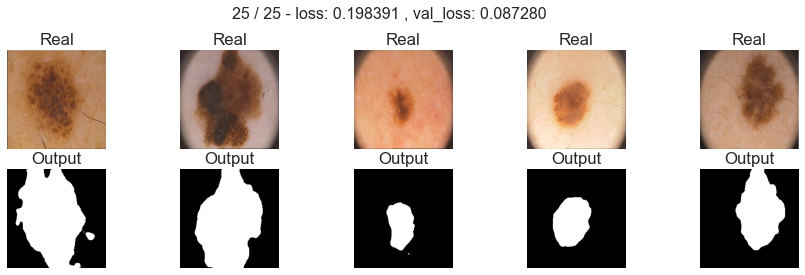

_______________
Training complete in 2m 25s
Best val IOU: 0.843056


In [21]:
model_dice = SegNet().to(device)
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
segnet_best_model_dice, segnet_statistics_with_dice_loss = train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val)

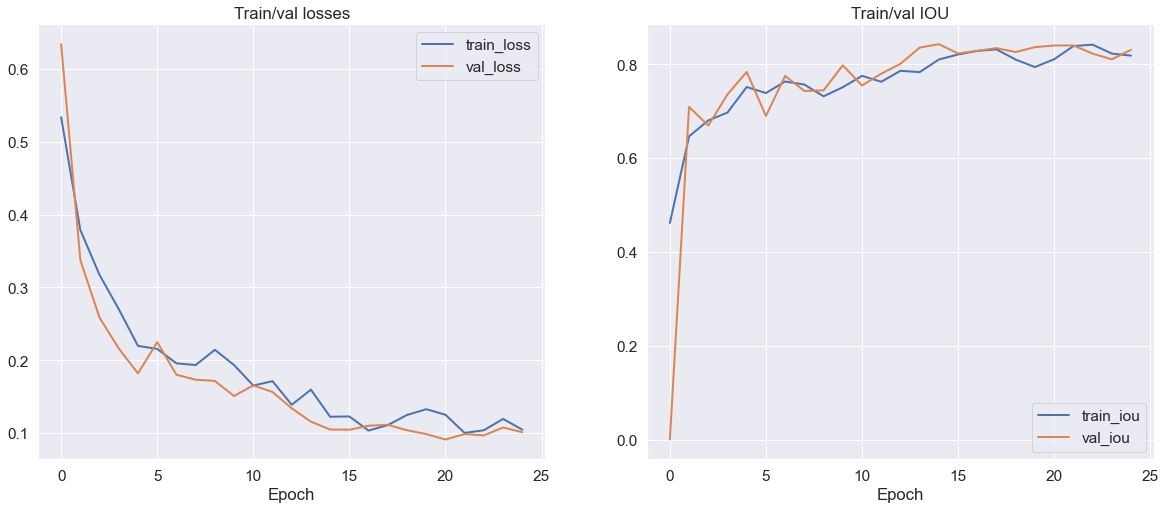

In [23]:
show_results(segnet_statistics_with_dice_loss, max_epochs)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Okay, now we know how to do BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i) )\right].$$

The problem with this loss is that it tends to benefit the **majority** class (background) over the **minority** class (front). Therefore, weighting factors are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight of $\alpha_i$ is defined as the reciprocal frequency of that pixel's class $i$, so that minority class observations weigh more relative to the majority class.

Another recent addition is the weighted pixel variant, which weights each pixel by the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

We fix the value $\gamma=2$.

--------------------------------------------------------------------------------


In [24]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1) 
    return -torch.mean(((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + eps))

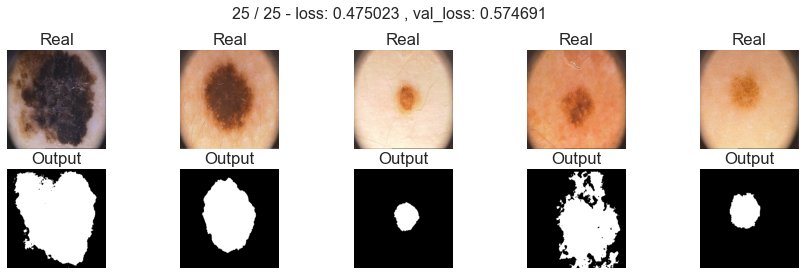

_______________
Training complete in 2m 23s
Best val IOU: 0.751713


In [25]:
model_focal = SegNet().to(device)
optimaizer = torch.optim.Adam(model_focal.parameters())
segnet_best_model_focal, segnet_statistics_with_focal_loss = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

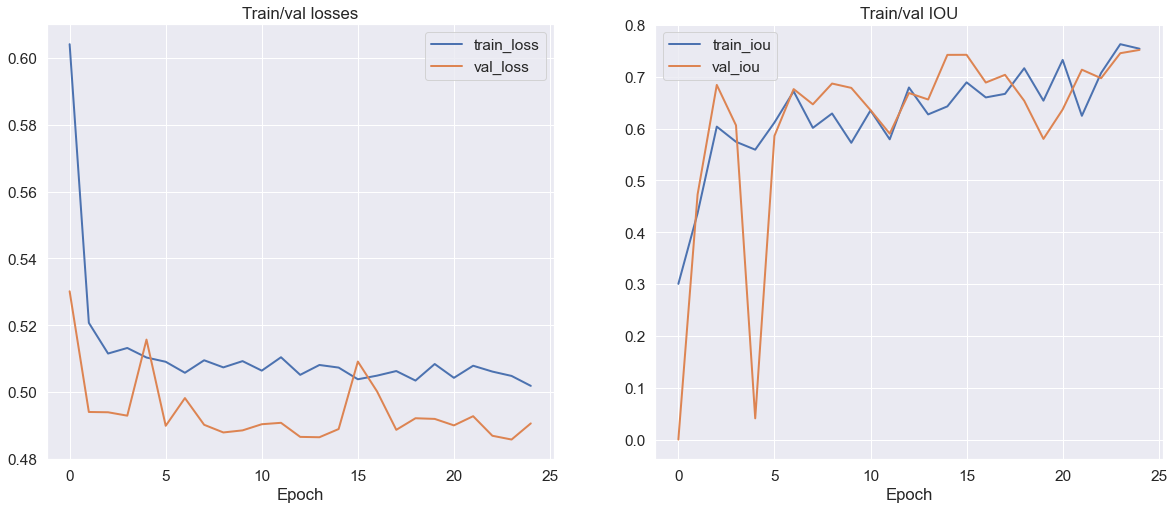

In [27]:
show_results(segnet_statistics_with_focal_loss, max_epochs)

[**3. Tversky loss:**](https://arxiv.org/abs/1706.05721) 

In [28]:
def tversky_loss(y_real, y_pred, alpha=0.3, beta=0.7, smooth=10):
    batch_size = y_pred.size(0)
    bg = 1 - y_real
    y_pred = y_pred.view(batch_size, -1)
    y_real = y_real.view(batch_size, -1)
    bg = bg.view(batch_size, -1)

    P_G = torch.sum(y_pred * y_real, 1)
    P_NG = torch.sum(y_pred * bg, 1)
    NP_G = torch.sum((1 - y_pred) * y_real, 1)

    return torch.mean(1. - (P_G / (P_G + alpha * P_NG + beta * NP_G + smooth)))

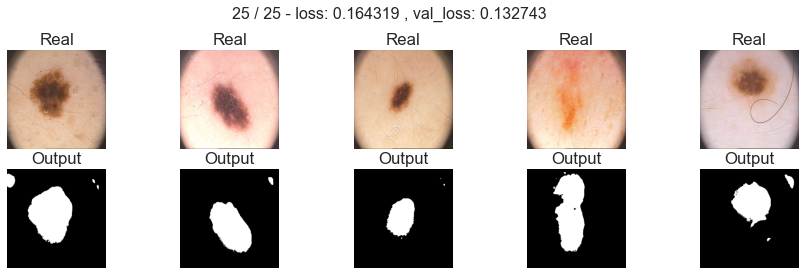

_______________
Training complete in 2m 23s
Best val IOU: 0.774761


In [29]:
model_tversky = SegNet().to(device)
optimaizer = torch.optim.Adam(model_tversky.parameters())
segnet_best_model_tversky, segnet_statistics_with_tversky_loss = train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

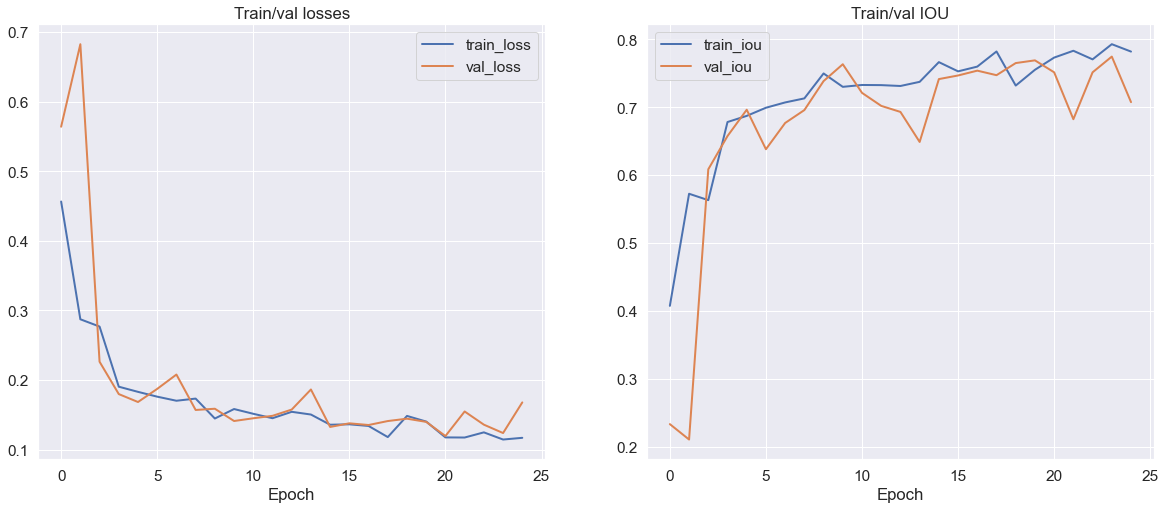

In [31]:
show_results(segnet_statistics_with_tversky_loss, max_epochs)

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — it is a neural network architecture that receives an image and outputs it. It was originally conceived for semantic segmentation (as we will use it), but it has been so successful that it has since been used in other contexts. Given a medical image as input, it will output an image in grayscale, where the intensity of each pixel depends on the probability that this pixel belongs to the area of interest to us.

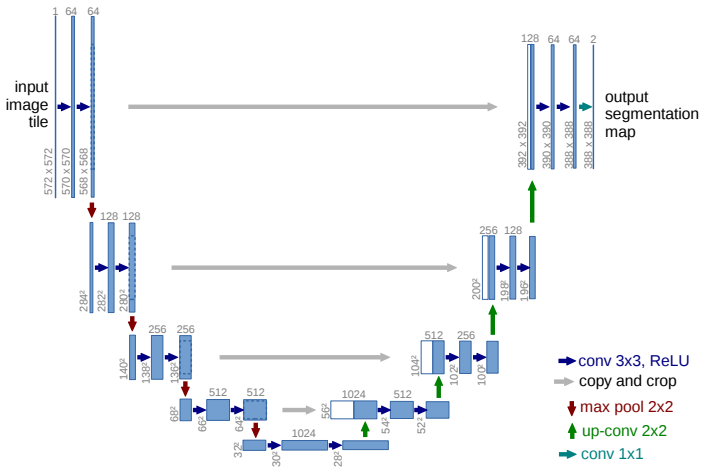

We still have an encoder and a decoder in our architecture, as in **SegNet**, but the distinguishing feature of this model is *skip-conenctions*, connecting parts of the decoder and encoder. That is, in order to pass a tensor to the decoder input, we concatenate the symmetrical output from the encoder and the output of the previous decoder layer.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [32]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(3, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                         ])
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(64, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.pool1 = nn.MaxPool2d(2, 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(128, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(256, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.pool2 =  nn.MaxPool2d(2, 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(256, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(512, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                         nn.Conv2d(512, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])
        
        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(1024 + 512, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(512, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.upsample1 =  nn.Upsample(64) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(*[
                                         nn.Conv2d(512 + 256, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(256, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(256 + 128, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(128 + 64, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64, 1, 3, padding=1)
                                         ])

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3) 
        return torch.sigmoid(d3)

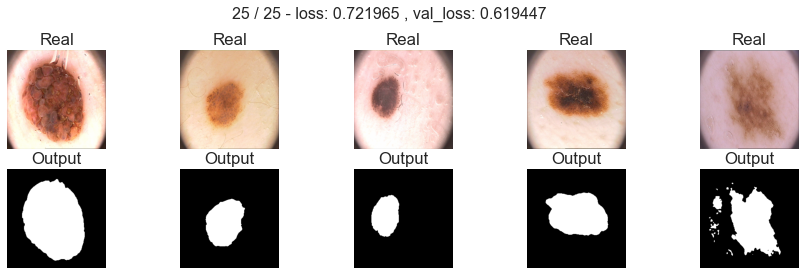

_______________
Training complete in 2m 56s
Best val IOU: 0.779636


In [33]:
unet_model = UNet().to(device)
unet_best_model_bce, unet_statistics_with_bce_loss = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

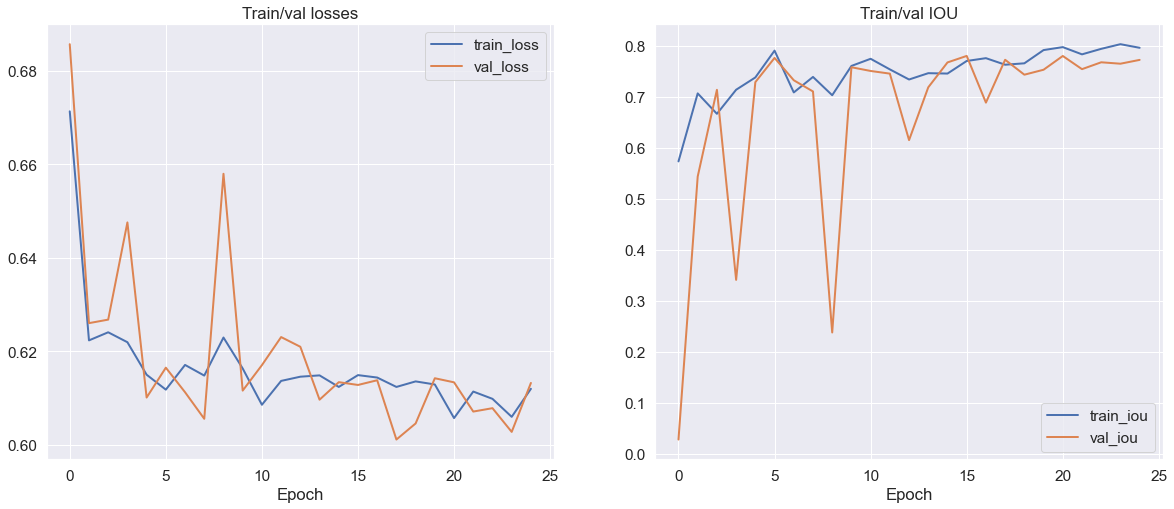

In [35]:
show_results(unet_statistics_with_bce_loss, max_epochs)

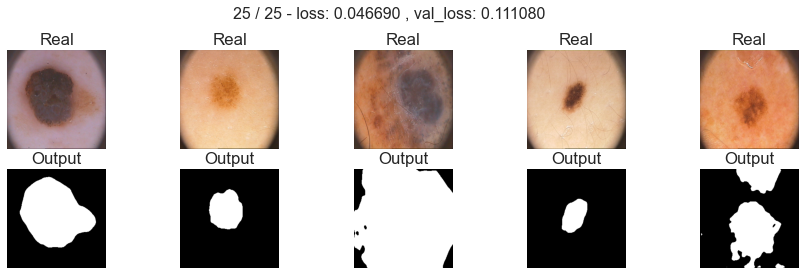

_______________
Training complete in 2m 56s
Best val IOU: 0.848637


In [36]:
unet_model_dice = UNet().to(device)
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr=1e-4)
unet_best_model_dice, unet_statistics_with_dice_loss = train(unet_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

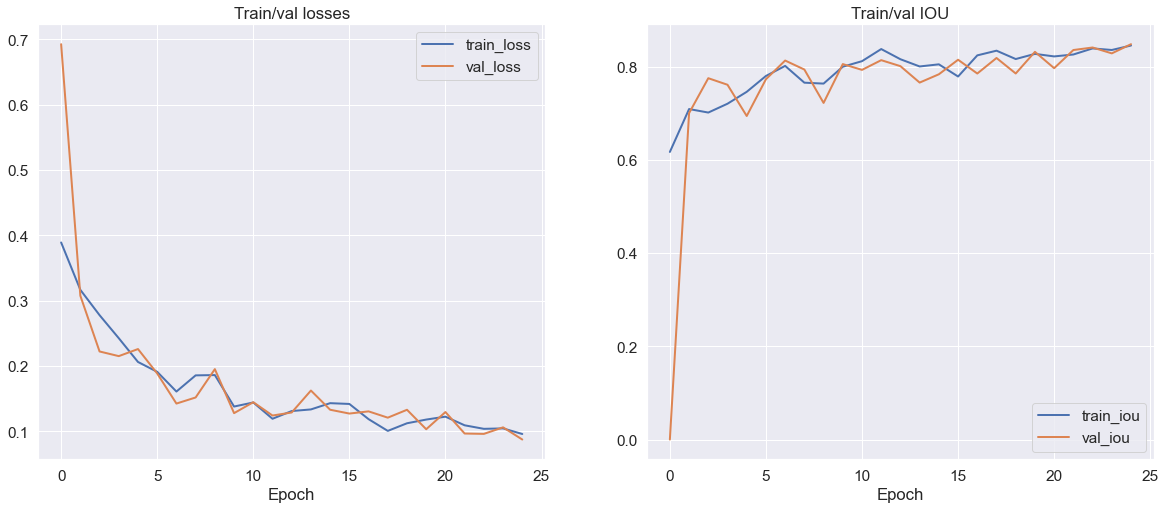

In [38]:
show_results(unet_statistics_with_dice_loss, max_epochs)

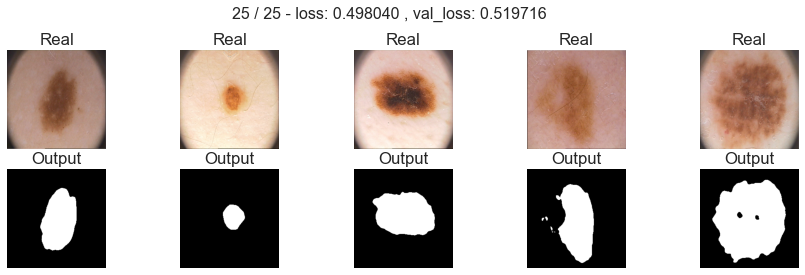

_______________
Training complete in 3m 0s
Best val IOU: 0.806274


In [39]:
unet_model_focal = UNet().to(device)
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-4)
unet_best_model_focal, unet_statistics_with_focal_loss = train(unet_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

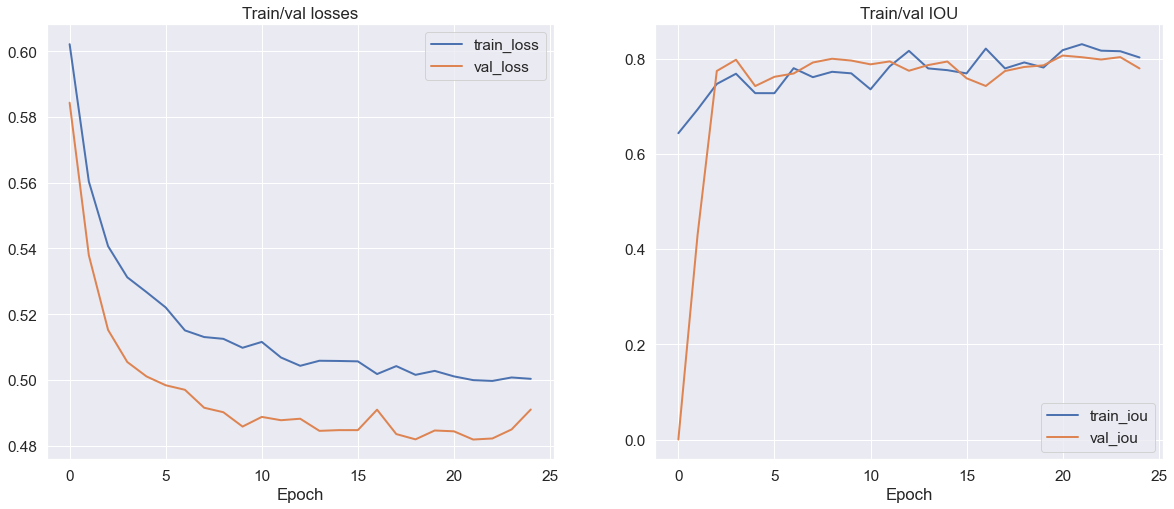

In [41]:
show_results(unet_statistics_with_focal_loss, max_epochs)

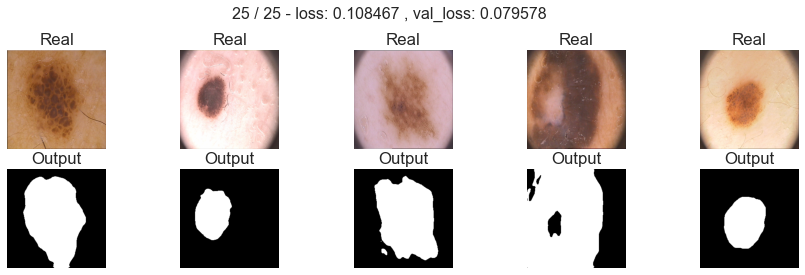

_______________
Training complete in 3m 5s
Best val IOU: 0.845638


In [42]:
unet_model_tversky = UNet().to(device)
optimizer = torch.optim.Adam(unet_model_tversky.parameters(), lr=1e-4)
unet_best_model_tversky, unet_statistics_with_tversky_loss = train(unet_model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

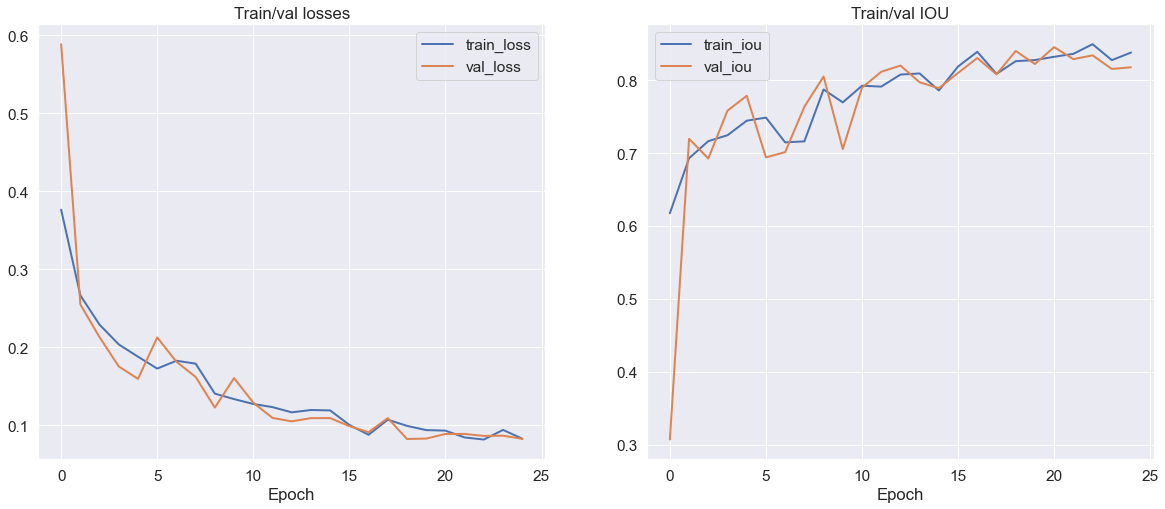

In [44]:
show_results(unet_statistics_with_tversky_loss, max_epochs)

New model by changing pooling type:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)




In [45]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(3, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                         ])
        self.pool0 = nn.Conv2d(64, 64, 2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(64, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.pool1 = nn.Conv2d(128, 128, 2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(128, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(256, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.pool2 =  nn.Conv2d(256, 256, 2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(256, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(512, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.pool3 = nn.Conv2d(512,512, 2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                         nn.Conv2d(512, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(1024, 1024, 3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])
        
        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(1024, 512, 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(1024, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(512, 512, 3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.upsample1 =  nn.ConvTranspose2d(512, 256, 2, stride=2) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(*[
                                         nn.Conv2d(512, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(256, 256, 3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(256, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128, 128, 3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(128, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64, 1, 3, padding=1)
                                         ])

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)
        return torch.sigmoid(d3)

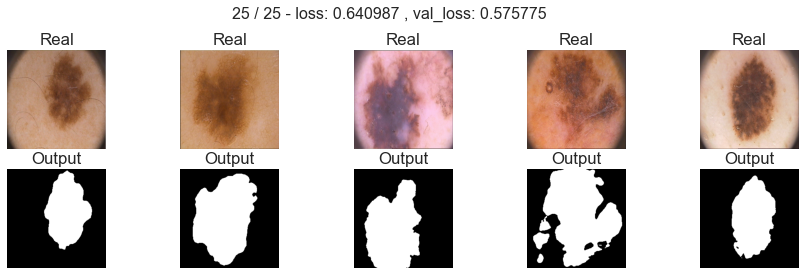

_______________
Training complete in 2m 43s
Best val IOU: 0.754238


In [46]:
unet2_model = UNet2().to(device)
unet2_best_model_bce, unet2_statistics_with_bce_loss = train(unet2_model, torch.optim.Adam(unet2_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

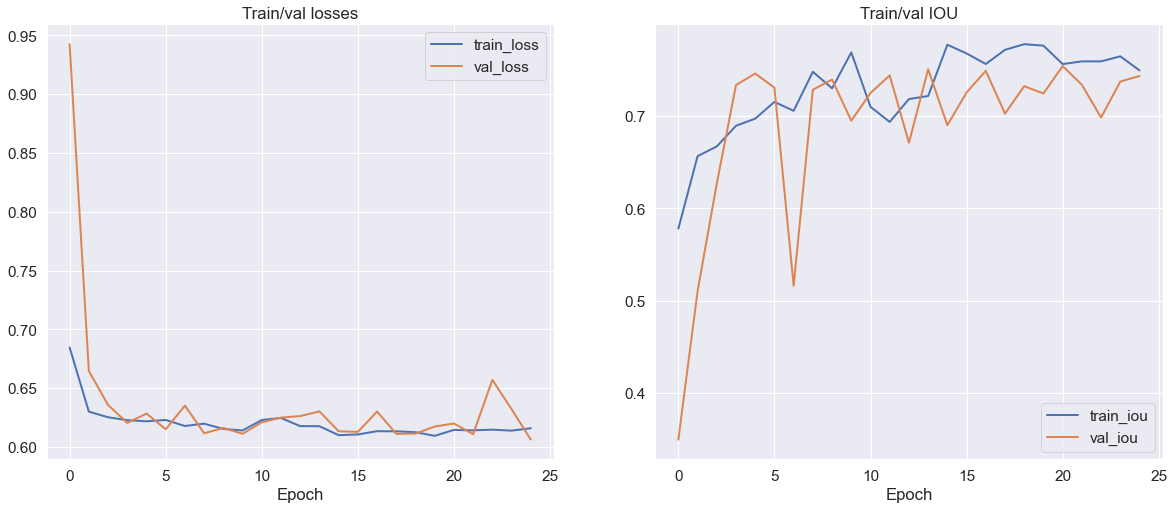

In [48]:
show_results(unet2_statistics_with_bce_loss, max_epochs)

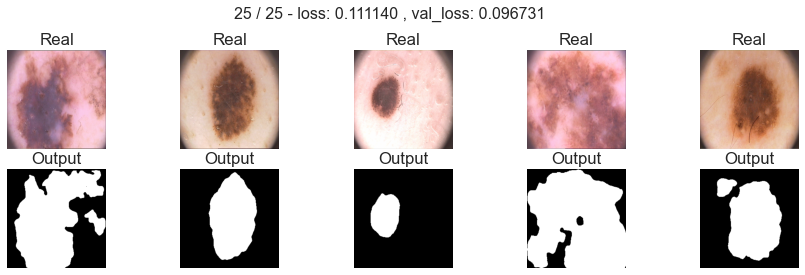

_______________
Training complete in 2m 31s
Best val IOU: 0.829496


In [49]:
unet2_model_dice = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_model_dice.parameters(), lr=1e-4)
unet2_best_model_dice, unet2_statistics_with_dice_loss = train(unet2_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

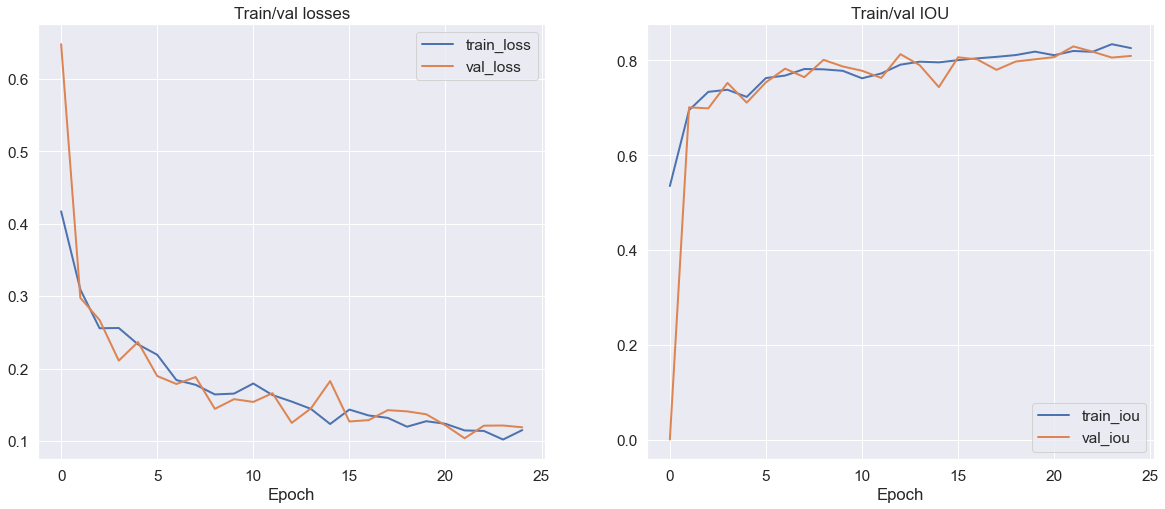

In [51]:
show_results(unet2_statistics_with_dice_loss, max_epochs)

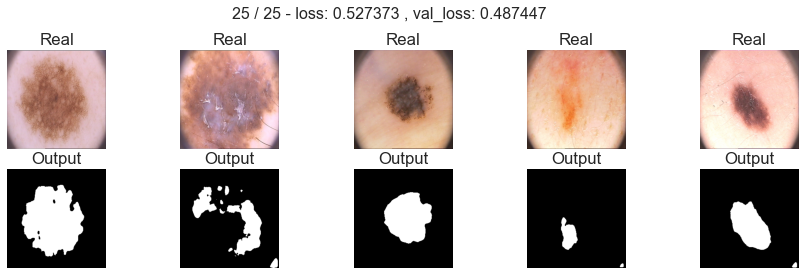

_______________
Training complete in 2m 35s
Best val IOU: 0.810886


In [52]:
unet2_model_focal = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_model_focal.parameters(), lr=1e-4)
unet2_best_model_focal, unet2_statistics_with_focal_loss = train(unet2_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

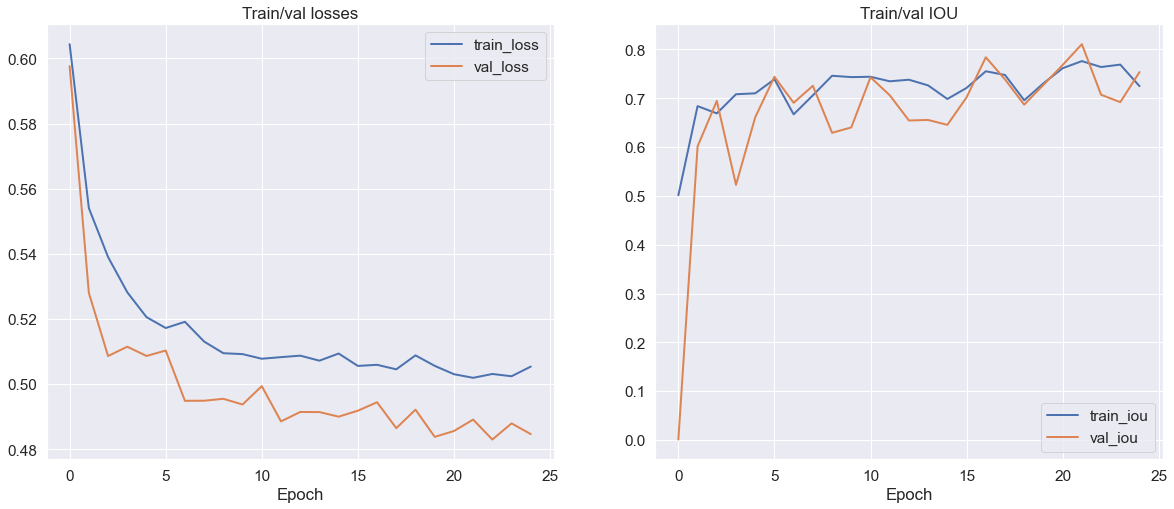

In [54]:
show_results(unet2_statistics_with_focal_loss, max_epochs)

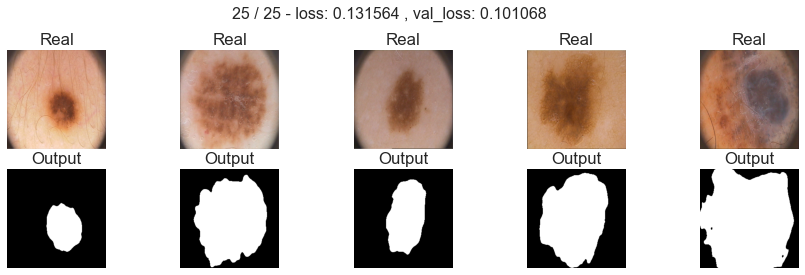

_______________
Training complete in 2m 39s
Best val IOU: 0.838049


In [55]:
unet2_model_tversky = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_model_tversky.parameters(), lr=1e-4)
unet2_best_model_tversky, unet2_statistics_with_tversky_loss = train(unet2_model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

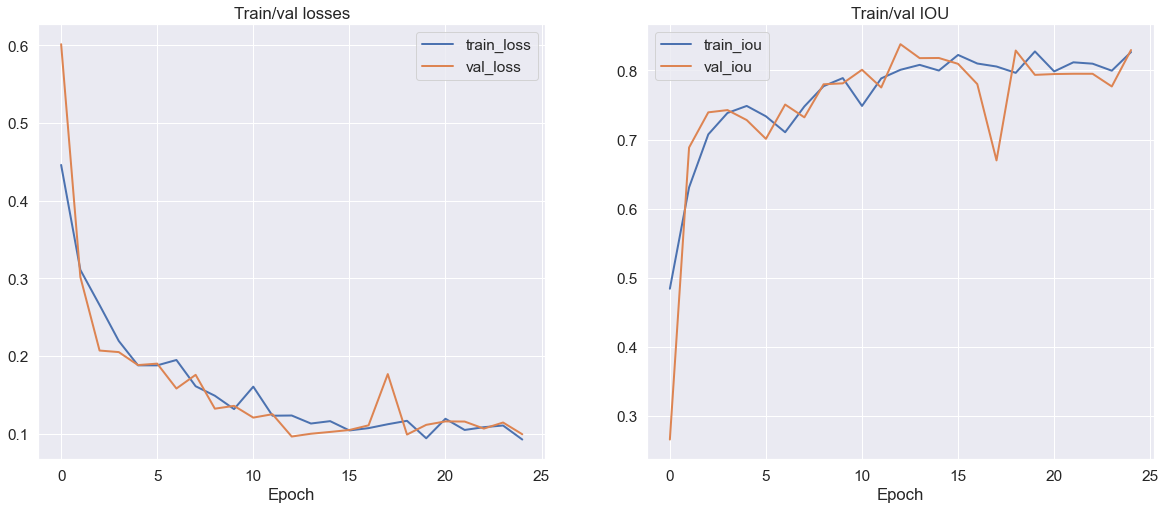

In [57]:
show_results(unet2_statistics_with_tversky_loss, max_epochs)

# Report: 

## Segnet statistics

In [58]:
train_stat_loss_segnet = [segnet_statistics_with_bce_loss[0], segnet_statistics_with_dice_loss[0], 
                          segnet_statistics_with_focal_loss[0], segnet_statistics_with_tversky_loss[0]]
train_stat_iou_segnet = [segnet_statistics_with_bce_loss[1], segnet_statistics_with_dice_loss[1], 
                          segnet_statistics_with_focal_loss[1], segnet_statistics_with_tversky_loss[1]]
val_stat_loss_segnet = [segnet_statistics_with_bce_loss[2], segnet_statistics_with_dice_loss[2], 
                          segnet_statistics_with_focal_loss[2], segnet_statistics_with_tversky_loss[2]]
val_stat_iou_segnet = [segnet_statistics_with_bce_loss[3], segnet_statistics_with_dice_loss[3], 
                          segnet_statistics_with_focal_loss[3], segnet_statistics_with_tversky_loss[3]]

## Unet statistics

In [59]:
train_stat_loss_unet = [unet_statistics_with_bce_loss[0], unet_statistics_with_dice_loss[0], 
                          unet_statistics_with_focal_loss[0], unet_statistics_with_tversky_loss[0]]
train_stat_iou_unet = [unet_statistics_with_bce_loss[1], unet_statistics_with_dice_loss[1], 
                          unet_statistics_with_focal_loss[1], unet_statistics_with_tversky_loss[1]]
val_stat_loss_unet = [unet_statistics_with_bce_loss[2], unet_statistics_with_dice_loss[2], 
                          unet_statistics_with_focal_loss[2], unet_statistics_with_tversky_loss[2]]
val_stat_iou_unet = [unet_statistics_with_bce_loss[3], unet_statistics_with_dice_loss[3], 
                          unet_statistics_with_focal_loss[3], unet_statistics_with_tversky_loss[3]]

## UnetV2 statistics

In [60]:
train_stat_loss_unet2 = [unet2_statistics_with_bce_loss[0], unet2_statistics_with_dice_loss[0], 
                          unet2_statistics_with_focal_loss[0], unet2_statistics_with_tversky_loss[0]]
train_stat_iou_unet2 = [unet2_statistics_with_bce_loss[1], unet2_statistics_with_dice_loss[1], 
                          unet2_statistics_with_focal_loss[1], unet2_statistics_with_tversky_loss[1]]

val_stat_loss_unet2 = [unet2_statistics_with_bce_loss[2], unet2_statistics_with_dice_loss[2], 
                          unet2_statistics_with_focal_loss[2], unet2_statistics_with_tversky_loss[2]]
val_stat_iou_unet2 = [unet2_statistics_with_bce_loss[3], unet2_statistics_with_dice_loss[3], 
                          unet2_statistics_with_focal_loss[3], unet2_statistics_with_tversky_loss[3]]

In [61]:
def show_itog(model, losses, train_statistics, val_statistics, max_epochs):
    fig, ax = plt.subplots(1, len(losses), figsize=(20, 5), sharey=True, tight_layout=True)
    ax = ax.ravel()
    for num, (train, val, loss) in enumerate(zip(train_statistics, val_statistics, losses)):
        ax[num].plot(range(max_epochs), train, label=f'train')
        ax[num].plot(range(max_epochs), val, label=f'val')
        ax[num].set_title(f'{model} {loss} loss')
        ax[num].legend()

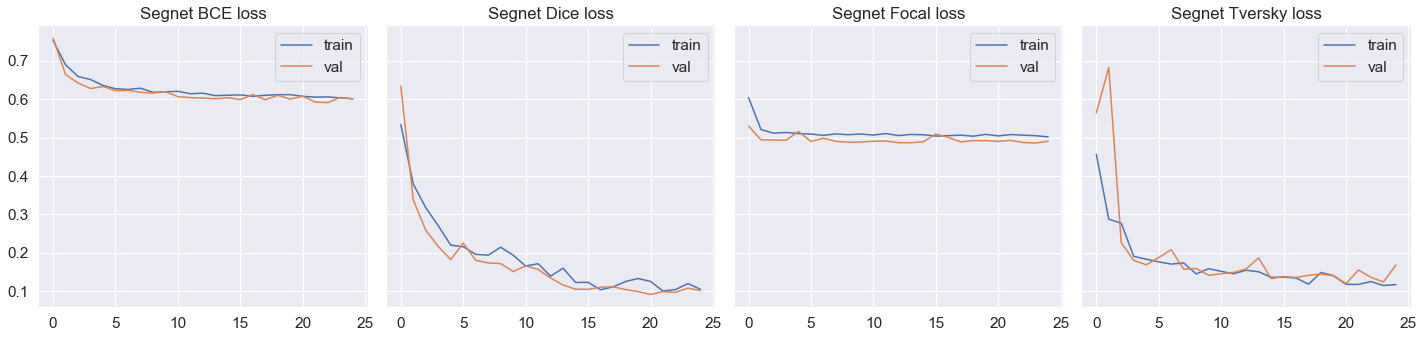

In [62]:
show_itog('Segnet', ['BCE', 'Dice', 'Focal', 'Tversky'], train_stat_loss_segnet, val_stat_loss_segnet, max_epochs)

Evaluating the graphs of the behavior of the model when assessed by different losses, the following can be noted:
- all models tend to overfit for a given number of epochs;
- the most successful loss in terms of retraining - Dice loss;
- the most successful in terms of the quality of education - Dice loss;
- the lowest quality of the model was achieved when evaluating the BCE model by loss;
- Tversky loss is qualitatively similar to Dice, but it is more unstable.
The best loss value for the SegNET architecture on validation is 0.087

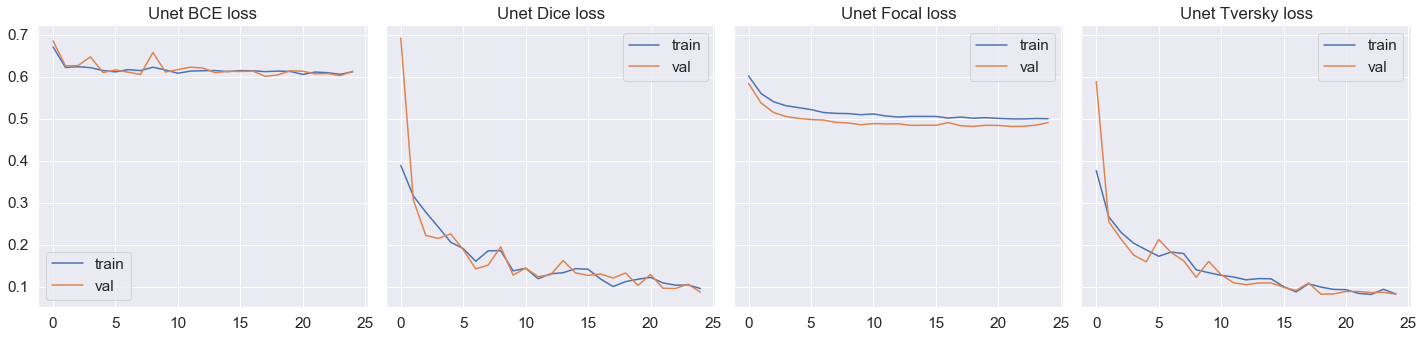

In [63]:
show_itog('Unet', ['BCE', 'Dice', 'Focal', 'Tversky'], train_stat_loss_unet, val_stat_loss_unet, max_epochs)

The trends identified in the study of the SegNET architecture are also traced for UNET'a. However, it seems that for this Tversky architecture, the loss is more stable. Best validation loss - 0.079 (achieved using Tversky loss)

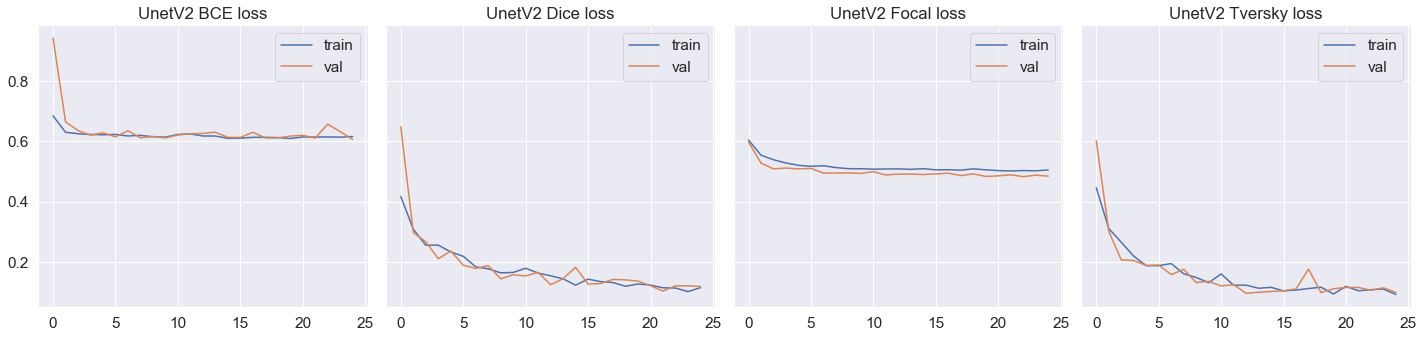

In [64]:
show_itog('UnetV2', ['BCE', 'Dice', 'Focal', 'Tversky'], train_stat_loss_unet2, val_stat_loss_unet2, max_epochs)

The architecture of UNTET V2 showed the best results on Dice and Tversky loss. However, it should be noted that the use of focal loss gives better results compared to previous architectures (loss value decreased by about 0.1). The best value on validation is 0.096(Dice loss)

**Conclusion**: All studied architectures have similar problems - overfitting, instability of losses, strange jumps in their values during validation and training. However, the best results in this study were shown by the Dice loss function, in 2 out of 3 cases the smallest loss on validation was achieved with its help.

## Comparison of three IOU models for each loss. (by Validation)

In [65]:
val_iou_bce = [segnet_statistics_with_bce_loss[3], unet_statistics_with_bce_loss[3], unet2_statistics_with_bce_loss[3]]
val_iou_dice = [segnet_statistics_with_dice_loss[3], unet_statistics_with_dice_loss[3], unet2_statistics_with_dice_loss[3]]
val_iou_focal = [segnet_statistics_with_focal_loss[3], unet_statistics_with_focal_loss[3], unet2_statistics_with_focal_loss[3]]
val_iou_tversky = [segnet_statistics_with_tversky_loss[3], unet_statistics_with_tversky_loss[3], unet2_statistics_with_tversky_loss[3]]

In [66]:
val_iou_segnet = [segnet_statistics_with_bce_loss[3], segnet_statistics_with_dice_loss[3], 
                  segnet_statistics_with_focal_loss[3], segnet_statistics_with_tversky_loss[3]]
val_iou_unet_v1 = [unet_statistics_with_bce_loss[3], unet_statistics_with_dice_loss[3], 
                  unet_statistics_with_focal_loss[3], unet_statistics_with_tversky_loss[3]]
val_iou_unet_v2 = [unet2_statistics_with_bce_loss[3], unet2_statistics_with_dice_loss[3], 
                  unet2_statistics_with_focal_loss[3], unet2_statistics_with_tversky_loss[3]]

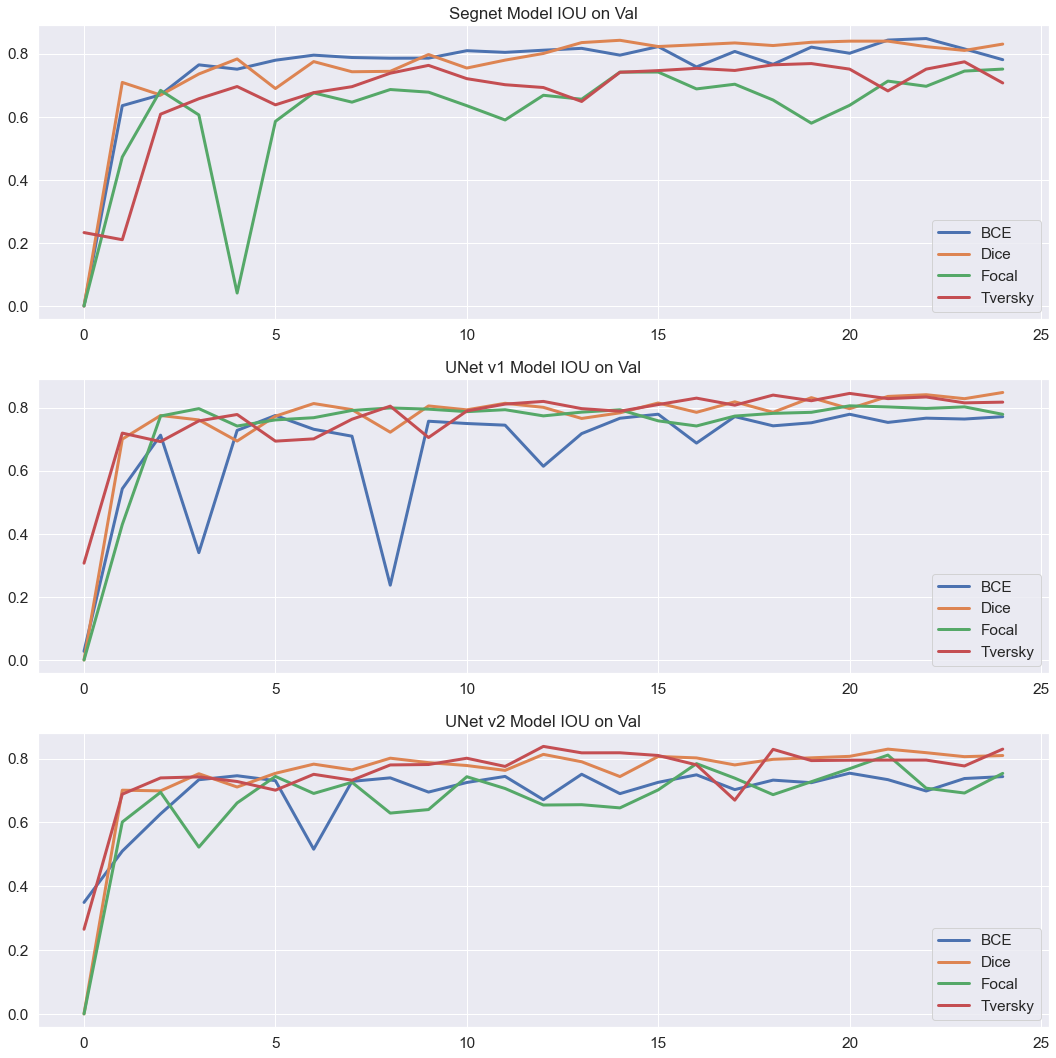

In [67]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), tight_layout=True)
ax = ax.ravel()
models = ['Segnet', 'UNet v1', 'UNet v2']
for num, (bce, dice, focal, tversky, model) in enumerate(zip(val_iou_bce, val_iou_dice, val_iou_focal,
                                                                   val_iou_tversky, models)):
    ax[num].plot(range(max_epochs), bce, label=f'BCE', linewidth=3)
    ax[num].plot(range(max_epochs), dice, label=f'Dice', linewidth=3)
    ax[num].plot(range(max_epochs), focal, label=f'Focal', linewidth=3)
    ax[num].plot(range(max_epochs), tversky, label=f'Tversky', linewidth=3)
    ax[num].set_title(f'{model} Model IOU on Val')
    ax[num].legend()

Analyzing the IOU charts for various losses, the architectures described above show a similar trend, which is logical: the highest quality results were obtained when using the Dice loss). Note also that Tversky loss when working with UNETs shows better results than for SegNETs. There are strange drawdowns at the beginning of training for BCE and focal losses. The highest IOU value was achieved on the UNET architecture using Dice loss - 0.848

## Predict on the test set of models with the best IOU on validation, comparison of results By models/losses

In [68]:
best_model_segnet_bce_test = score_model(segnet_best_model_bce, iou_pytorch, data_tr)
best_model_segnet_dice_test = score_model(segnet_best_model_dice, iou_pytorch, data_tr)
best_model_segnet_focal_test = score_model(segnet_best_model_focal, iou_pytorch, data_tr)
best_model_segnet_tversky_test = score_model(segnet_best_model_tversky, iou_pytorch, data_tr)

best_model_unet_bce_test = score_model(unet_best_model_bce, iou_pytorch, data_tr)
best_model_unet_dice_test = score_model(unet_best_model_dice, iou_pytorch, data_tr)
best_model_unet_focal_test = score_model(unet_best_model_focal, iou_pytorch, data_tr)
best_model_unet_tversky_test = score_model(unet_best_model_tversky, iou_pytorch, data_tr)

best_model_unet2_bce_test = score_model(unet2_best_model_bce, iou_pytorch, data_tr)
best_model_unet2_dice_test = score_model(unet2_best_model_dice, iou_pytorch, data_tr)
best_model_unet2_focal_test = score_model(unet2_best_model_focal, iou_pytorch, data_tr)
best_model_unet2_tversky_test = score_model(unet2_best_model_tversky, iou_pytorch, data_tr)

In [69]:
test_results = pd.DataFrame({'Segnet': [best_model_segnet_bce_test, best_model_segnet_dice_test, best_model_segnet_dice_test,
                                        best_model_segnet_tversky_test],
                             'Unet': [best_model_unet_bce_test, best_model_unet_dice_test, best_model_unet_focal_test,
                                        best_model_unet_tversky_test],
                             'Unet_v2': [best_model_unet2_bce_test, best_model_unet2_dice_test, best_model_unet2_focal_test,
                                        best_model_unet2_tversky_test]}, index=['BCE', 'Dice', 'Focal', 'Tversky'])

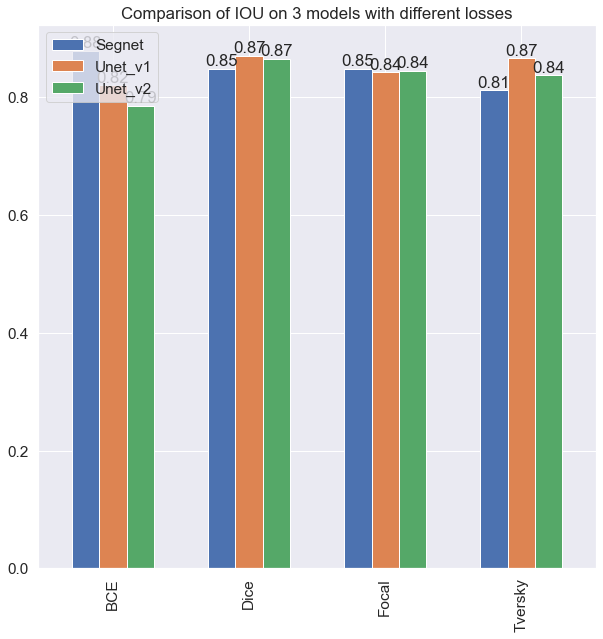

In [70]:
fig, ax = plt.subplots()
test_results.plot(kind='bar', figsize=(10, 10), width=0.6, title='', ax=ax)
ax.set_title('Comparison of IOU on all models with different losses')
ax.legend()

for i in range(3):
    ax.bar_label(ax.containers[i], fmt='%.2f')

Comparing the values of the best models on validation, we observe, among other things, the previously described dependence:
- the highest values of the target metric are achieved by the UNET architecture models when using the Dice loss;
- the best SegNET model produces the highest value of the metric when using ALL loss;
- Focal loss turned out to be the worst option for all architectures;
- Tversky loss shows the best values only for unmodified UNET.